# Import packages

In [2]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: eval_nav.py
# --- Creation Date: 16-02-2022
# --- Last Modified: Thu 17 Feb 2022 00:34:50 AEDT
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Evaluate Navigators with a pretrained attr discrim network.
"""
%matplotlib inline

import os

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F

import legacy

In [321]:
generator_pkl = 'ffhq512'
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_atl_fixedES_neig30_ffhq512_1/00008-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedES-neig_30-afc_3-nfc_3-atl_14-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_1-kimg1000-batch28/network-snapshot-001000.pkl'
navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pcabase_ffhq512/00002-ffhq512-z_50-lr_0.01-wals_1-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_none-nt_pca-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0-ncol_2-dys_T-vars_0.5-kimg80-batch6/network-snapshot-init.pkl'
attr_discrim_pkl = '/mnt/hpc_hdd_2/repo_results/stylegan2/results_vc2_byvae_ffhq512/00033-vc2_gan-ffhq-4gpu-config-c/converted_ps_sc/00000-convert/attr_discrim_model/00005-00012-pseudo_attr_data-attr-ch_3-dout_24-netn_resnet50-pretr_True-loss_reg-tsize_17000-kimg25000-batch64-noaug/network-snapshot-002016.pkl'

attr_names = ['azimuth',
                'haircolor',
                'smile',
                'gender',
                'main_fringe',
                'left_fringe',
                'age',
                'light_right',
                'light_left',
                'light_vertical',
                'hair_style',
                'clothes_color',
                'saturation',
                'ambient_color',
                'elevation',
                'neck',
                'right_shoulder',
                'left_shoulder',
                'background_1',
                'background_2',
                'background_3',
                'background_4',
                'right_object',
                'left_object']
used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17] # more accurate

seed = 2022
#outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00028-ffhq512-z_10-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_16-dys_T-vars_0.5-kimg160-batch32/eval_nav'
# outdir = os.path.join(os.path.dirname(navigator_pkl), 'eval_nav')
outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/compare_navs'
n_samples_per = 1000
var_scale_ls = [1, 1, 1, 1, 1, 1,
                1, 1, 1, 1, 1, 1,
                1, 1, 1, 1, 1, 1,
                1, 1, 1, 1, 1, 1]
batch_gpu = 16
truncation_psi = 0.5

In [102]:
print('Loading generator networks from "%s"...' % generator_pkl)

resume_specs = {
    'ffhq256':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl',
    'ffhq512':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl',
    'ffhq1024':    'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl',
    'celebahq256': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/celebahq-res256-mirror-paper256-kimg100000-ada-target0.5.pkl',
    'lsundog256':  'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/lsundog-res256-paper256-kimg100000-noaug.pkl',
}

assert generator_pkl is not None
if generator_pkl in resume_specs:
    generator_pkl = resume_specs[generator_pkl] # predefined url

device = torch.device('cuda:0')
# device = torch.device('cpu')
with dnnlib.util.open_url(generator_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].requires_grad_(False).to(device) # type: ignore

def load_M(navigator_pkl):
    with open(navigator_pkl, 'rb') as f:
        resume_data = pickle.load(f)
        M = resume_data['M'].requires_grad_(False).to(device)
    return M

with open(attr_discrim_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    D = resume_data['D_ema'].requires_grad_(False).to(device)
print('Done loading.')

Loading generator networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl"...
Done loading.


In [16]:
print(D)

BackboneNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [322]:
os.makedirs(outdir, exist_ok=True)

In [94]:
def show(img):
    img = (img - img.min()) / (img.max() - img.min())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [206]:
def try_var_scale_ls(M, var_scale_ls, idx, seed=0, truncation_psi=0.3):
    torch.random.manual_seed(seed)
    z = torch.randn([1, G.z_dim], device=device)
    c = torch.randn([1, G.c_dim], device=device)
    w = G.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)
    dirs = M(w) # [b, nv_dim, num_ws, w_dim]
    w_1 = w - dirs[:, idx] * var_scale_ls[idx]
    w_2 = w + dirs[:, idx] * var_scale_ls[idx] # [b, num_ws, w_dim]
    print(idx)
    image = G.synthesis(w_1, noise_mode='const')
    image_2 = G.synthesis(w_2, noise_mode='const')
    print(image.shape)

    show(torch.cat([image, image_2], dim=3)[0].cpu())
# try_var_scale_ls(M, var_scale_ls=[1] * M.nv_dim, idx=0, seed=20)

In [310]:
# Eval for each variation dim
# var_scale_ls = [5, 1, 1, 1, 5, 3, 1, 3, 5, 5]
#var_scale_ls = [1] * M.nv_dim

def evaluate_model(G, M, D, var_scale_ls=[2]*30, max_nv_dim=30, truncation_psi=0.5, n_samples_per=1000):
    attr_score_shift_summary_ls = []
    img_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
    for i in range(max_nv_dim):
        attr_score_shift_ls = []
        print(f'Processing dim {i}')
        for j in range(0, n_samples_per, batch_gpu):
            b = batch_gpu if j+batch_gpu <= n_samples_per else n_samples_per-j

            z = torch.from_numpy(rand_state.randn(b, G.z_dim)).to(device)
            c = torch.from_numpy(rand_state.randn(b, G.c_dim)).to(device)
            w = G.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)

            dirs = M(w) # [b, nv_dim, num_ws, w_dim]
            w_1 = w - dirs[:, i] * var_scale_ls[i]
            w_2 = w + dirs[:, i] * var_scale_ls[i] # [b, num_ws, w_dim]

            images = torch.cat([G.synthesis(w_1, noise_mode='const'),
                                G.synthesis(w_2, noise_mode='const')], dim=0) # (2b, c, h, w)
        
            # Normalize to fit model D
            # images_flat = images.view(2*b, -1)
            # img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
            # images = (images - img_min.view(2*b, 1, 1, 1)) / (img_max - img_min).view(2*b, 1, 1, 1)
            images = (images + 1.) / 2. # From [-1, 1] to [0, 1]
            images = (images - img_mean) / img_std
        
            attr_pred = D(images) # [2b, nlabel]
            attr_score_shift = attr_pred[b:] - attr_pred[:b] # [b, nlabel]
            attr_score_shift_ls.append(attr_score_shift.to('cpu'))
        attr_score_shift_i = torch.cat(attr_score_shift_ls, dim=0).mean(0) # [nlabel]
        attr_score_shift_summary_ls.append(attr_score_shift_i)
    return attr_score_shift_summary_ls

In [591]:
def summarize(attr_score_shift_summary_ls, name='pca'):
    attr_score_shift_summary = torch.stack(attr_score_shift_summary_ls, dim=0) # [nv_dim, nlabel]
    print(attr_score_shift_summary.shape)

    scores_np = np.abs(attr_score_shift_summary.numpy())
    scores_normed = scores_np[:, used_attr_idx] / scores_np[:, used_attr_idx].max(axis=1, keepdims=True)
    
    scores_copy = scores_np.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:30, -1] - scores_copy[:30, -2]).mean()
    print('before normed:', score)
    
    scores_copy = scores_normed.copy()
    scores_copy.sort(axis=-1)
    score = (scores_copy[:30, -1] - scores_copy[:30, -2]).mean()
    print('after normed:', score)
    
    attr_discovered = (scores_normed == 1.).any(axis=0)
    n_discovered = attr_discovered.sum()
    print('attr_discovered:', attr_discovered)
    print('n_discovered:', n_discovered)
    
    plt.clf()
    plt.imshow(scores_normed[:30], cmap='viridis')
    # plt.imshow(scores_np[:30], cmap='viridis')
    plt.colorbar()
    #plt.show()
    plt.savefig(os.path.join(outdir, f'attr_score_shift_{name}.pdf'))
    np.savetxt(os.path.join(outdir, f"scores_raw_{name}.csv"), scores_np, delimiter=",")
    np.savetxt(os.path.join(outdir, f"scores_normed_{name}.csv"), scores_normed, delimiter=",")
    np.savetxt(os.path.join(outdir, f"score_{name}.csv"), score[np.newaxis], delimiter=",")
    np.savetxt(os.path.join(outdir, f"n_discovered_{name}.csv"), n_discovered[np.newaxis], delimiter=",")
    return score

In [660]:
attr_names = ['azimuth',#0
                'haircolor',#1
                'smile',#2
                'gender',#3
                'main_fringe',#4
                'left_fringe',#5
                'age',#6
                'light_right',#7
                'light_left',#8
                'light_vertical',#9
                'hair_style',#10
                'clothes_color',#11
                'saturation',#12
                'ambient_color',#13
                'elevation',#14
                'neck',#15
                'right_shoulder',#16
                'left_shoulder',#17
                'background_1',#18
                'background_2',#19
                'background_3',#20
                'background_4',#21
                'right_object',#22
                'left_object']#23
used_attr_idx = [0,1,2,3,4,5,6,7,8,9,10,11,14,16,17] # more accurate
# used_attr_idx = list(range(24))
# === contra-1 not goood
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_atl_fixedES_neig30_ffhq512_1/00008-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedES-neig_30-afc_3-nfc_3-atl_14-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_1-kimg1000-batch28/network-snapshot-001000.pkl'
# === contra-2
navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_dis_div_neg_ffhq512/good-00014-ffhq512-z_32-lr_0.1-wals_1-prand_F-vart_s-mcont_1-dis_256-dic_3-mir_T-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_300-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_16-dys_T-vars_0.5-kimg200-batch12/network-snapshot-000200.pkl'
# === pca_base
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_pcabase_ffhq512/00002-ffhq512-z_50-lr_0.01-wals_1-prand_F-vart_s-mcont_0-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_none-nt_pca-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0-ncol_2-dys_T-vars_0.5-kimg80-batch6/network-snapshot-init.pkl'
# === sefa_base
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_sefabase_ffhq512/00000-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_none-nt_sefa-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg1-batch24/network-snapshot-init.pkl'
# === recog-at_fixed-nv_fixed
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_recogbase_ffhq512/00002-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-mcont_0-sensor_alex-Rpre_T-recg_1-vs_0.25-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixed-neig_4-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg1000-batch8/network-snapshot-001000.pkl'
M = load_M(navigator_pkl)
print('Done')

Done


31
torch.Size([1, 3, 512, 512])


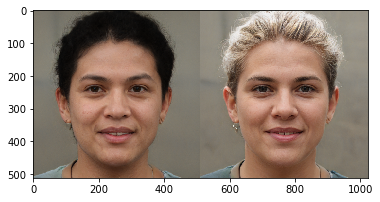

In [742]:
# pca_var_scale_ls = [3,3,3,3,3,3,
#                    2,2,2,2,2,2,
#                    2,2,2,2,2,2,
#                    2,2,2,2,2,2,
#                    2,2,2,2,2,2]
# try_var_scale_ls(M, var_scale_ls=pca_var_scale_ls, idx=3, seed=2013)

# === contra-1
# contra_var_scale_ls = [0.5,5,5,0.5,0.5,1,
#                       1,0.5,0.5,1,0.5,0.5,
#                       0.5,5,1,0.5,0.5,1,
#                       5,1,3,1,0.5,1,
#                       0.5,0.5,3,1,0.5,1]
# try_var_scale_ls(M, var_scale_ls=contra_var_scale_ls, idx=3, seed=112)

# === contra-2
contra_var_scale_ls = [1,5,5,0.5,1,5,
                      0.5,1,0.5,0.5,5,0.5,
                      2,3,0.5,0.3,2,0.3,
                      0.3,5,2,2,1,2,
                      2,0.5,0.5,0.5,5,0.5,
                      0.5,0.5]
try_var_scale_ls(M, var_scale_ls=contra_var_scale_ls, idx=31, seed=20)

# sefa_var_scale_ls = [2,3,4,3,3,3,
#                       3,3,3,3,2,2,
#                       2,2,1.5,1.5,1.5,1.5,
#                       1.5,1.5,1.5,1.5,1.5,1.5,
#                       1.5,1.5,1.5,1.5,1.5,1.5]
# try_var_scale_ls(M, var_scale_ls=sefa_var_scale_ls, idx=29, seed=2013)

# recog_var_scale_ls = [0.5,0.5,0.5,0.5,0.5,5,
#                       5,0.5,0.5,5,0.5,0.5,
#                       1,0.5,0.5,0.3,0.5,0.5,
#                       5,1,1,0.5,0.5,5,
#                       0.5,0.3,0.3,0.5,0.5,5]
# try_var_scale_ls(M, var_scale_ls=recog_var_scale_ls, idx=29, seed=2016)

In [746]:
# pca_attr_ls = evaluate_model(G, M, D, var_scale_ls=pca_var_scale_ls, max_nv_dim=30)
contra_attr_ls = evaluate_model(G, M, D, var_scale_ls=contra_var_scale_ls, max_nv_dim=32)
# sefa_attr_ls = evaluate_model(G, M, D, var_scale_ls=sefa_var_scale_ls, max_nv_dim=32)
# recog_attr_ls = evaluate_model(G, M, D, var_scale_ls=recog_var_scale_ls, max_nv_dim=30)

Processing dim 0
Processing dim 1
Processing dim 2
Processing dim 3
Processing dim 4
Processing dim 5
Processing dim 6
Processing dim 7
Processing dim 8
Processing dim 9
Processing dim 10
Processing dim 11
Processing dim 12
Processing dim 13
Processing dim 14
Processing dim 15
Processing dim 16
Processing dim 17
Processing dim 18
Processing dim 19
Processing dim 20
Processing dim 21
Processing dim 22
Processing dim 23
Processing dim 24
Processing dim 25
Processing dim 26
Processing dim 27
Processing dim 28
Processing dim 29
Processing dim 30
Processing dim 31


torch.Size([30, 24])
before normed: 0.11633584
after normed: 0.24930407
attr_discovered: [ True  True  True  True  True False False  True  True  True False False
  True False False]
n_discovered: 9


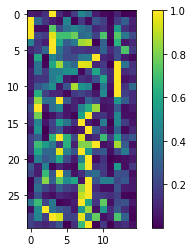

In [656]:
pca_score = summarize(pca_attr_ls, name='pca')

torch.Size([32, 24])
before normed: 0.088413715
after normed: 0.19451417
attr_discovered: [ True  True  True  True  True False  True  True  True False  True False
  True  True  True]
n_discovered: 12


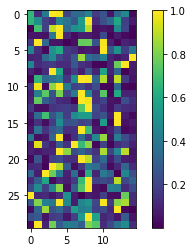

In [747]:
contra_score = summarize(contra_attr_ls, name='contra')

torch.Size([30, 24])
before normed: 0.14408532
after normed: 0.24852294
attr_discovered: [ True  True False  True  True False False  True  True  True False False
  True False False]
n_discovered: 8


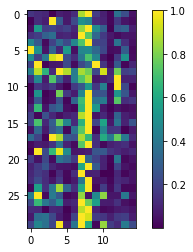

In [658]:
sefa_score = summarize(sefa_attr_ls)

torch.Size([30, 24])
before normed: 0.08382918
after normed: 0.30761334
attr_discovered: [ True  True  True  True  True False False  True  True False False False
  True False False]
n_discovered: 8


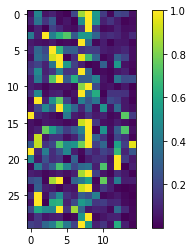

In [659]:
recog_score = summarize(recog_attr_ls, name='recog')